### **Before you run this make sure you have the OPENAI_API_KEY environment variable declared**

### 1 Create a StateGraph
#### Now you can create a basic chatbot using LangGraph. This chatbot will respond directly to user messages.

Start by creating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine". We'll add `nodes` to represent the llm and functions our chatbot can call and `edges` to specify how the bot should transition between these functions.

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

### Our graph can now handle two key tasks:

1. Each `node` can receive the current `State` as input and output an update to the state.
2. Updates to `messages` will be appended to the existing list rather than overwriting it, thanks to the prebuilt `add_messages` function used with the Annotated syntax.


### 2 Add a node
Next, add a "chatbot" node. Nodes represent units of work and are typically regular Python functions.

Let's first select a chat model:

In [3]:
import os
from langchain.chat_models import init_chat_model
llm = init_chat_model("openai:gpt-4.1")

 We can now incorporate the chat model into a simple node:

In [4]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

**Notice** how the `chatbot` node function takes the current `State` as input and returns a dictionary containing an updated `messages` list under the key "messages". This is the basic pattern for all LangGraph node functions.

The `add_messages` function in our State will append the LLM's response messages to whatever messages are already in the state.

### 3 Add an entry point
Add an `entry` point to tell the graph **where to start its work** each time it is run

In [5]:
graph_builder.add_edge(START, "chatbot")

### 4 Compile the graph
Before running the graph, we'll need to compile it. We can do so by calling `compile()` on the graph builder. This creates a `CompiledGraph` we can invoke on our state.

In [6]:
graph = graph_builder.compile()

### 5 Visualize the graph
You can visualize the graph using the `get_graph` method and one of the "draw" methods, like `draw_ascii` or `draw_png`. The draw methods each require additional dependencies.

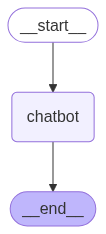

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### 6 Run the chatbot
Now run the chatbot!

In [8]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: As of June 2024, the latest Gemini model from Google is **Gemini 1.5**. The primary versions include **Gemini 1.5 Pro** and **Gemini 1.5 Flash**. These models are the newest advancements in Google's family of multimodal, large language models and are available via the Google Gemini platform and the Gemini API.

- **Gemini 1.5 Pro:** Offers high-level reasoning, multimodal capabilities (text, images, audio, and video), and supports long-context understanding (up to 1 million tokens in some cases).
- **Gemini 1.5 Flash:** Optimized for speed and lower latency while maintaining strong multimodal performance.

Google continues to enhance these models and may announce newer versions in the upcoming months, but as of now, **Gemini 1.5** is the latest available publicly.
Goodbye!
